# Evaluate inner auROC for main models of training jobs from CHTC for

gps study with version v6 using nested_1_x_10_3_x_10 CV

John Curtin & Claire Punturieri  
October 8, 2024

# Housekeeping

## Code status

Complete for use in GPS study as of 10/2024.

## Notes

Generates a median auROC histogram for best model configuration.

# Set Up

## Set Up Environment

### Study parameters

In [ ]:
study <- params$study
cv <- params$cv
model <- params$model
algorithms <- params$algorithms
version <- params$version


### Defaults

In [ ]:

# handle conflicts
options(conflicts.policy = "depends.ok")
devtools::source_url("https://github.com/jjcurtin/lab_support/blob/main/fun_ml.R?raw=true")


ℹ SHA-1 hash of file is "77e91675366f10788c6bcb59fa1cfc9ee0c75281"

### Packages for script

In [ ]:

library(tidyverse)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

ℹ SHA-1 hash of file is "c045eee2655a18dc85e715b78182f176327358a7"

ℹ SHA-1 hash of file is "a58e57da996d1b70bb9a5b58241325d6fd78890f"

ℹ SHA-1 hash of file is "75cc6f7b855da59c240908bd936834b4da01285b"

### Absolute paths

In [ ]:
path_models <- format_path(str_c("studydata/risk/models/", study))


# Generate performance metric plot

Load in data.

In [ ]:
metrics <- read_csv(here::here(path_models, str_c("best_config_",
                                             version, "_",
                                             cv, "_", model, ".csv")))


Rows: 300 Columns: 17
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (3): algorithm, feature_set, resample
dbl (13): config_num, outer_split_num, inner_split_num, hp1, hp2, hp3, sens,...
lgl  (1): split_num

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Generate plot across all *inner* folds.

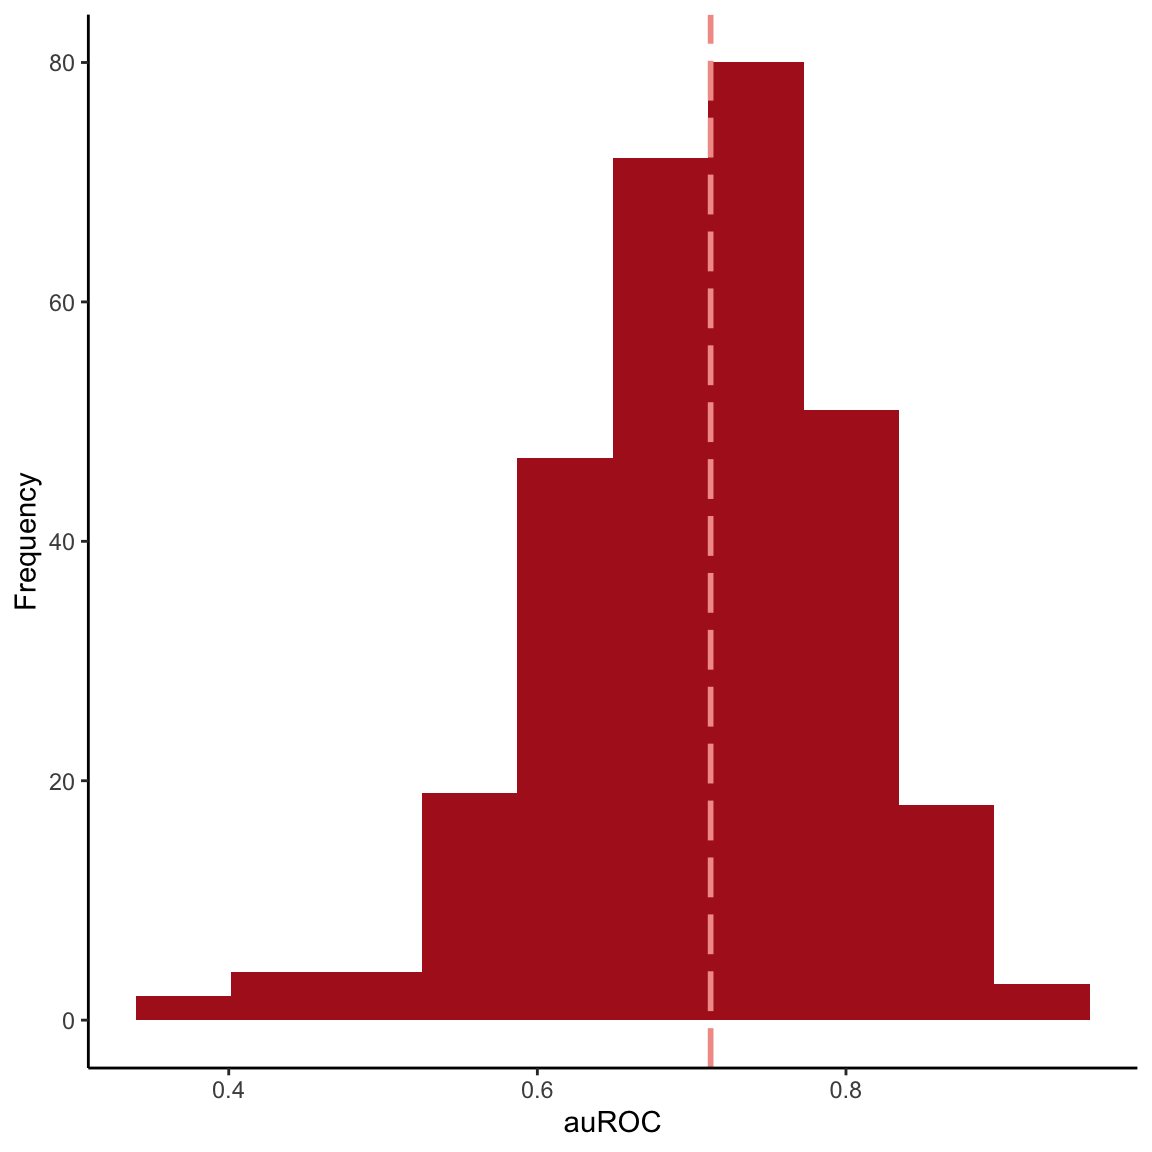

In [ ]:

metrics |> 
  ggplot(aes(x = roc_auc)) +
  geom_histogram(bins = 10, fill = c("#af1f21")) +
  geom_vline(xintercept = median(metrics$roc_auc), color = c("#f29c96"), lwd = 1, linetype="longdash") +
  labs(x = "auROC", y = "Frequency")


# Posteriors

In [ ]:
# from ?perf_mod()
# Repeated CV (id = repeat, id2 = fold within repeat)
# with a common variance:  statistic ~ model + (model | id2/id)

if(file.exists(here::here(path_models, str_c("pp_",
                                    version, "_",
                                    cv, "_", model, ".rds")))) {
  
  message("Model exists! Loading in...")
  
  pp <- read_rds(here::here(path_models, str_c("pp_",
                                    version, "_",
                                    cv, "_", model, ".rds")))
} else {
  
    message("Model does not exist! Running and saving out...")
  
  set.seed(101)
  
  pp <- metrics |>
    select(outer_split_num, inner_split_num, roc_auc) |> 
    rename(id = outer_split_num,
           id2 = inner_split_num) |> 
    perf_mod(formula = statistic ~ 1 + (1 | id/id2),
             # prior_intercept = rstanarm::student_t(autoscale = TRUE),
             # prior = rstanarm::student_t(autoscale = TRUE),
             transform = tidyposterior::logit_trans,  # for skewed & bounded AUC
             iter = 13000, chains = 4,
             adapt_delta = .99999999,
             # cores = 4, seed = 12345,
             family = gaussian)  


  pp |> write_rds(here::here(path_models, str_c("pp_",
                                                version, "_",
                                                cv, "_", model, ".rds")))
}


Model exists! Loading in...

Posterior graph as density plot

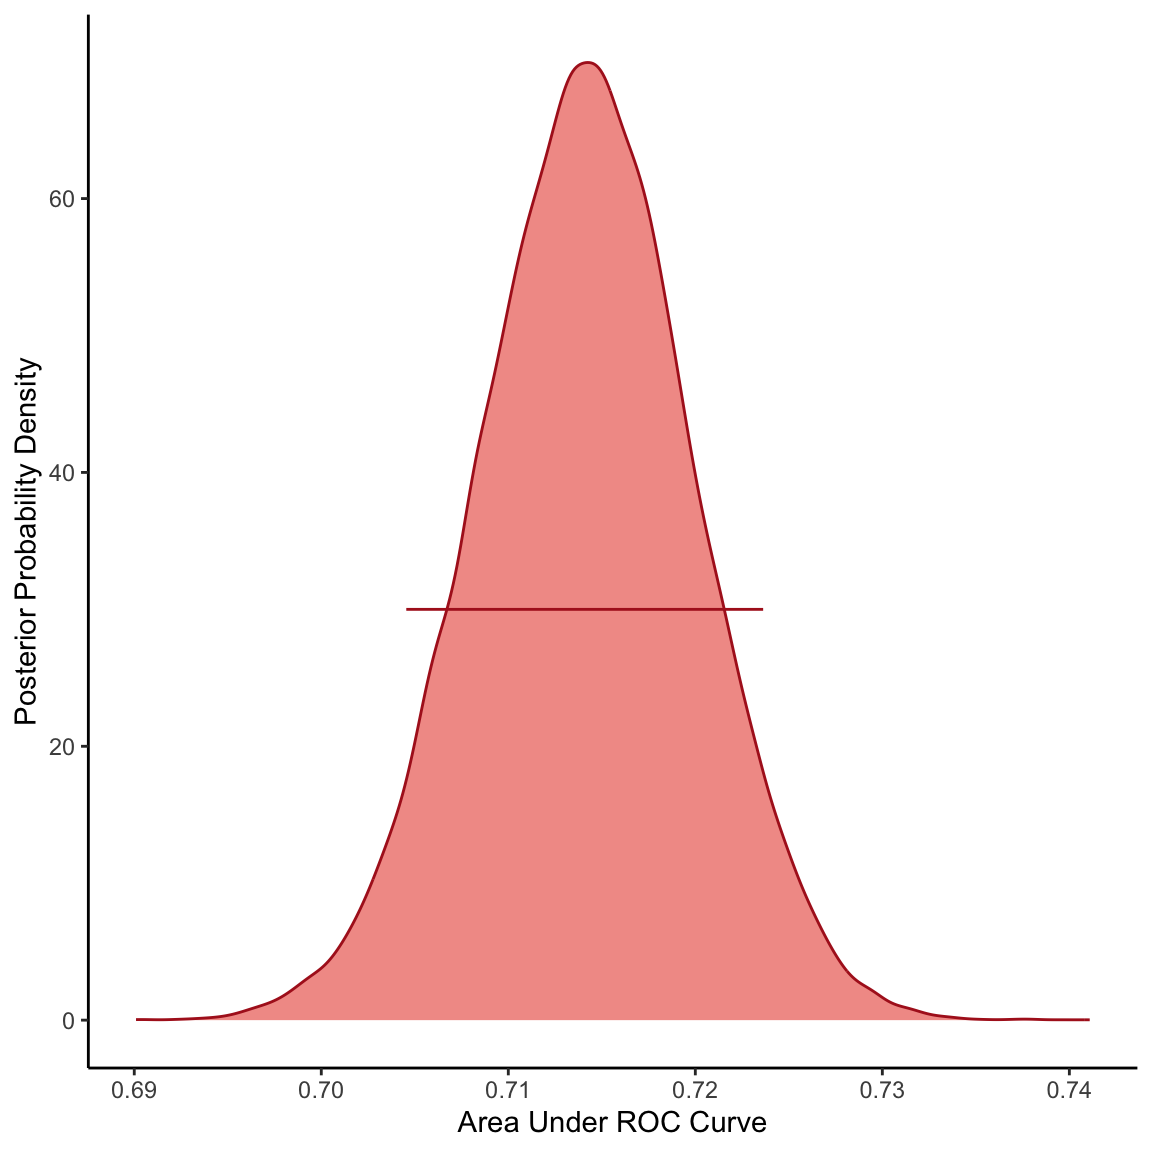

In [ ]:
pp_tidy <- pp |> 
  tidy(seed = 123)

ci_day <- pp_tidy |> 
  summary() |> 
  mutate(y = 30)

# vertical line for the median
pp_tidy |> 
  ggplot(aes(x = posterior)) + 
  geom_density(color = c("#af1f21"), fill = c("#f29c96"), alpha = 1) +
  geom_segment(mapping = aes(y = y, yend = y, x = lower, xend = upper), color = c("#af1f21"),
                data = ci_day) +
  ylab("Posterior Probability Density") +
  xlab("Area Under ROC Curve")
